# Project: Build a Traffic Sign Recognition Classifier

# Step O: Load The Data

In [ ]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'

testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

The pickled data is a dictionary with 4 key/value pairs:

1) features' is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels). 2) labels' is a 1D array containing the label/class id of the traffic sign. The file signnames.csv contains id -> name mappings for each id. 3) sizes' is a list containing tuples, (width, height) representing the original width and height the image. 4) coords' is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of a traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# Step 1: Dataset Summary & Exploration

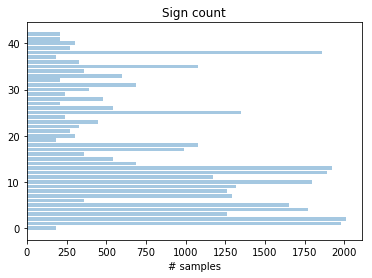

35


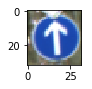

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import scipy.ndimage

# Visualizations will be shown in the notebook.
%matplotlib inline
label_freq = np.bincount(y_train)
max_inputs = np.max(label_freq)

plt.barh(np.arange(n_classes), label_freq, align='center', alpha=0.4)

plt.xlabel('# samples')
plt.title('Sign count')

plt.show()

index = random.randint(0, len(X_train))
image = X_train[index]
plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [4]:
# retrieve class labels 
import csv
with open('signnames.csv', 'r') as file:
    reader = csv.reader(file)
    class_names = dict(reader)
    
# take a random sample per class
sample_image_per_class = []
for n in range(n_classes):
    sample_image_per_class.append(np.random.choice(np.where(y_train==n)[0]))
    
show_images = X_train[sample_image_per_class,:,:,:]

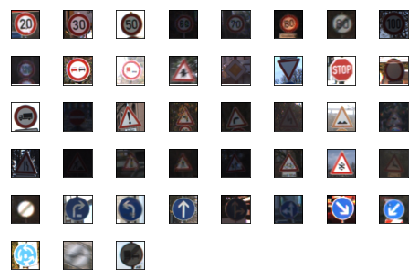

In [5]:
#show sign per class
def show_signs(image_array, width, height):
    fig = plt.figure()
    for j in range(image_array.shape[0]):
        ax = fig.add_subplot(height, width, j+1)
        ax.imshow(image_array[j], cmap='gray')
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    
show_signs(show_images, 8, 6)

# Step 2: Design & Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the German Traffic Sign Dataset.
There are various aspects to consider when thinking about this problem: Neural network architecture Play around preprocessing techniques (normalization, rgb to grayscale, etc)
Number of examples per label (some have more than others). Generate fake data.

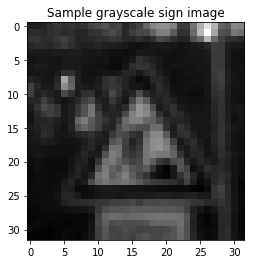

In [6]:
import cv2
from copy import deepcopy

#convert the images to grayscale
X_train_gr = [cv2.cvtColor(X_train[n], cv2.COLOR_BGR2GRAY)
              for n in range(np.shape(X_train)[0])]
X_test_gr = [cv2.cvtColor(X_test[n], cv2.COLOR_BGR2GRAY)
             for n in range(np.shape(X_test)[0])]
    
y_train_gr = deepcopy(y_train)

plt.imshow(random.choice(X_train_gr), cmap='gray')
plt.title('Sample grayscale sign image')
plt.show()


In [7]:
# functions to transform the images
# trasformation 1
def trans_1(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[0,0],[32,5],[0,32],[32,27]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 2
def trans_2(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[0,5],[32,0],[0,27],[32,32]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 3
def trans_3(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[5,0],[27,0],[0,32],[32,32]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 4 - skew image 1
def trans_4(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[0,0],[27,5],[5,32],[32,27]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# trasformation 5 - skew image 2
def trans_5(image):
    pts1 = np.float32([[0,0],[32,0],[0,32],[32,32]])
    pts2 = np.float32([[5,5],[32,0],[0,27],[27,32]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(image,M,(32,32))
    return dst

# transformation 6 - rotation +5 to +15
def trans_6(image):
    # chose rotation angle randomly from a uniform distribution
    rot_ang = int(np.random.uniform(10)) + 5
    M = cv2.getRotationMatrix2D((16,16),rot_ang,1)
    dst = cv2.warpAffine(image,M,(32,32))
    return dst## visualize the transformations to be performed on the dataset


# transformation 7 - rotation -5 to -15
def trans_7(image):

    # chose rotation angle randomly from a uniform distribution
    rot_ang = int(np.random.uniform(-10)) - 5
    M = cv2.getRotationMatrix2D((16,16),rot_ang,1)
    dst = cv2.warpAffine(image,M,(32,32))
    return dst

Transformations performed for data augmentation:


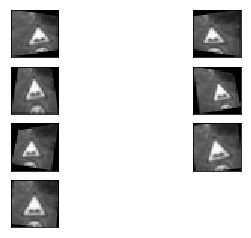

In [8]:
## visualize the transformations to be performed on the dataset
sample_im = random.choice(X_train_gr)

transformations = [trans_1, trans_2, trans_3, trans_4, trans_5, trans_6, trans_7]

for i, tr in enumerate(transformations):
    transformed = tr(sample_im)
    plt.subplot(4,2,i+1)
    plt.imshow(transformed, cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

print('Transformations performed for data augmentation:')

In [9]:
# global variable to keep all original dataset and add augmented dataset
all_X_train = deepcopy(X_train_gr)
all_y_train = deepcopy(y_train_gr)
    
## use data augmentation to beef up classes that has low frequencies

# augment data function:
def augment_data(augment_fn, X_data,y_data):
    global all_X_train
    global all_y_train
   
    print('old shape:')
    print(np.shape(all_y_train))

    class_freq = np.bincount(all_y_train)

    mean_freq = int(np.average(class_freq))
    print('mean frequency:', mean_freq)

    transform_X = []
    transform_y = []
    for i, im in enumerate(X_data):
        if class_freq[y_data[i]] < mean_freq:
            im_trans = augment_fn(im)
            transform_X.append(im)
            transform_y.append(y_data[i])

    all_X_train = np.append(all_X_train, transform_X, axis=0)
    all_y_train = np.append(all_y_train, transform_y, axis=0)

    print('new shape:')
    print(np.shape(all_X_train))
    print(np.shape(all_y_train))

    class_freq = np.bincount(all_y_train)
    display_image_id = 1000

    plt.figure(1)
    n = np.size(class_freq)

    index = np.arange(np.shape(class_freq)[0])
    plt.bar(index, class_freq, 1)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.show

old shape:
(34799,)
mean frequency: 809
new shape:
(43918, 32, 32)
(43918,)
old shape:
(43918,)
mean frequency: 1021
new shape:
(50968, 32, 32)
(50968,)
old shape:
(50968,)
mean frequency: 1185
new shape:
(60508, 32, 32)
(60508,)
old shape:
(60508,)
mean frequency: 1407
new shape:
(73077, 32, 32)
(73077,)
old shape:
(73077,)
mean frequency: 1699
new shape:
(81417, 32, 32)
(81417,)
old shape:
(81417,)
mean frequency: 1893
new shape:
(93866, 32, 32)
(93866,)
old shape:
(93866,)
mean frequency: 2182
new shape:
(110996, 32, 32)
(110996,)


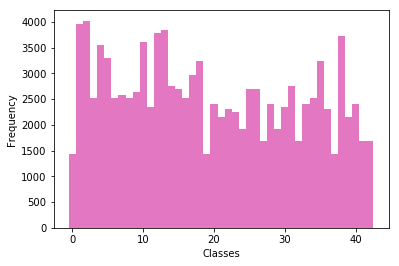

In [10]:
# augmentation 
augment_data(trans_1, X_train_gr, y_train_gr)
augment_data(trans_2, X_train_gr, y_train_gr)
augment_data(trans_3, X_train_gr, y_train_gr)
augment_data(trans_4, X_train_gr, y_train_gr)
augment_data(trans_5, X_train_gr, y_train_gr)
augment_data(trans_6, X_train_gr, y_train_gr)
augment_data(trans_7, X_train_gr, y_train_gr)

In [11]:
# empty arrays for new training and validation datasets
new_X_train = []
new_y_train = []

new_X_val = []
new_y_val = []

for n in range(n_classes):
    # find indexes of each classes in the dataset
    # randomly choose from and make up a validation set for each class
    where_id = np.where(all_y_train==n)[0]
    np.random.shuffle(where_id)
    
    # make training data 80% of orginal dataset
    cut_off = 0.75
    new_X_train.append(all_X_train[where_id][:int(np.shape(where_id)[0]*cut_off)])
    new_X_val.append(all_X_train[where_id][int(np.shape(where_id)[0]*cut_off):])
    
    new_y_train.append(all_y_train[where_id][:int(np.shape(where_id)[0]*cut_off)])
    new_y_val.append(all_y_train[where_id][int(np.shape(where_id)[0]*cut_off):])
else:
    # stack up training and validation sets
    new_X_train = np.vstack(new_X_train)
    new_X_val = np.vstack(new_X_val)
    new_y_train = np.hstack(new_y_train)
    new_y_val = np.hstack(new_y_val)
    
# confirm shape of datasets made
print('shape of training data',np.shape(new_X_train))
print('shape of validation data', np.shape(new_X_val))

shape of training data (83245, 32, 32)
shape of validation data (27751, 32, 32)


In [12]:
print('Creating network architecture...')
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# inputs and parameters
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

# keep probability for dropout
keep_prob = tf.placeholder(tf.float32)

# one-hot encode the labels
one_hot_y = tf.one_hot(y, 43)

# learning rate
l_rate = 0.001

Creating network architecture...


In [13]:
# define archtecture
def signs_classify(x, keep_prob):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 24), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(24))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation 1.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 12x12x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 24, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation 2.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 14x14x32. Output = 7x7x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 3: Convolutional. Output = 7x7x64.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation 3.
    conv3 = tf.nn.relu(conv3)

    # Pooling. Input = 5x5x64. Output = 2x2x64.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 2x2x64. Output = 256.
    fc0   = flatten(conv3)
    
    # Layer 3: Fully Connected. Input = 256. Output = 512.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(256, 512), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(512))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation 3.
    fc1    = tf.nn.relu(fc1)
    
    # dropout 1
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 512. Output = 256.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(512, 256), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(256))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation 4.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Output Layer: Fully Connected. Input = 256. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(256, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


In [14]:
# training functions
logits = signs_classify(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
# compute the mean over all samples
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = l_rate)
training_operation = optimizer.minimize(loss_operation)

In [15]:
# model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data, drop_out):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: drop_out})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [16]:
# reshape dataset to suitable input for network
new_X_train = np.reshape(new_X_train, (np.shape(new_X_train)[0],32,32,1))
new_X_val = np.reshape(new_X_val, (np.shape(new_X_val)[0],32,32,1))

# normalize dataset [naive]
new_X_train = (np.array(new_X_train) - 128.0)/256.0
new_X_val = (np.array(new_X_val) - 128.0)/256.0

In [17]:
from sklearn.utils import shuffle

save_file = './sign_classify.ckpt'
EPOCHS = 15
BATCH_SIZE = 128
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(new_X_train, new_y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(new_X_val, new_y_val, drop_out=1.0)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, save_file)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.839

EPOCH 2 ...
Validation Accuracy = 0.950

EPOCH 3 ...
Validation Accuracy = 0.973

EPOCH 4 ...
Validation Accuracy = 0.983

EPOCH 5 ...
Validation Accuracy = 0.987

EPOCH 6 ...
Validation Accuracy = 0.990

EPOCH 7 ...
Validation Accuracy = 0.990

EPOCH 8 ...
Validation Accuracy = 0.996

EPOCH 9 ...
Validation Accuracy = 0.996

EPOCH 10 ...
Validation Accuracy = 0.996

EPOCH 11 ...
Validation Accuracy = 0.996

EPOCH 12 ...
Validation Accuracy = 0.997

EPOCH 13 ...
Validation Accuracy = 0.996

EPOCH 14 ...
Validation Accuracy = 0.996

EPOCH 15 ...
Validation Accuracy = 0.998

Model saved


In [18]:
new_X_test = np.reshape(X_test_gr, (np.shape(X_test_gr)[0],32,32,1))

# normalize dataset [naive]
new_X_test = (np.array(new_X_test) - 128.0)/256.0

meta_graph_file = save_file+'.meta'

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(meta_graph_file)
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # model evaluation
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    test_accuracy = sess.run(
        accuracy_operation,
        feed_dict={x: new_X_test, y: y_test, keep_prob: 1.0})

print('Test Accuracy: {}'.format(test_accuracy))

Test Accuracy: 0.9456848502159119


In [ ]:
import os

no_of_imgs = 6
disp_imgs = []
disp_imgs_gray = []

for i in os.listdir('sign_italy/'):
    image = cv2.imread('sign_italy/'+i)
    dim = (32,32)

    # convert to grayscale
    grayed = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    disp_imgs.append(np.asarray(grayed))
    
    grayed = cv2.cvtColor(grayed, cv2.COLOR_RGB2GRAY)
    
    disp_imgs_gray.append(np.asarray(grayed))

show_signs(np.array(disp_imgs), 4,4)

# normalize new test data
test_imgs_gray = ((np.array(disp_imgs_gray)-128.0)/256.0).reshape(no_of_imgs,32,32,1)

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph(meta_graph_file)
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # model evaluation
    prediction = tf.argmax(logits, 1)

    test_prediction = sess.run(
        prediction,
        feed_dict={x: test_imgs_gray, keep_prob: 1.0})
for i in range(no_of_imgs):
    print('Prediction: {} \t| {}'.format(test_prediction[i], 
                                            class_names[str(test_prediction[i])]))

In [ ]:
Prediction: 1 	| Speed limit (30km/h)
Prediction: 39 	| Keep left
Prediction: 26 	| Traffic signals
Prediction: 11 	| Right-of-way at the next intersection
Prediction: 18 	| General caution
Prediction: 34 	| Turn left ahead
    


In [ ]:
# get the softmax probabilities for n best prediction probabilities.
predict_no = 5
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('sign_classify.ckpt.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    # model evaluation
    prediction = tf.nn.softmax(logits)

    test_prediction = sess.run(tf.nn.top_k(
        prediction,k=predict_no),
        feed_dict={x: test_imgs_gray , keep_prob: 1.0})

# print('Predictions: {}'.format(test_prediction))

In [ ]:
# plot visualization of softmax probabilities
index = np.arange(predict_no)
probabilities, predict_classes = test_prediction

candidates = [1,2,3,4,5]
for i,im in enumerate(candidates):
    fig = plt.figure(figsize=(20, 20)) 
    plt.subplot(5,2,(i+1)*2-1)
    plt.imshow(disp_imgs[im])
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

    
    plt.subplot(5,2,(i+1)*2)
    plt.barh(index, probabilities[im], align='center')
    plt.yticks(index,[class_names[str(predict_classes[im][i])] for i in index] )
#     plt.axis([0,1,-0.5,2.5])

plt.tight_layout()

NameError: name 'preprocess_data' is not defined

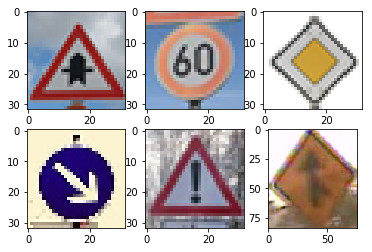

In [25]:
import glob
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

def display_images(images, cmap=None, num_rows=3):
    """
        Displays an image array a grid with number of rows=num_rows
    """
    num_images = len(images)
    num_cols = int(num_images/num_rows)
    fig, axes = plt.subplots(num_rows, num_cols)
    
    for i, ax in enumerate(axes.flat):
        # Only plot the valid images
        if i < num_images:
            img = images[i]

            # Plot image.
            if(cmap):
                ax.imshow(img, cmap=cmap)
            else:
                ax.imshow(img)

def read_images(fileNames, display=True):
    images = []
    for file in fileNames:
        image = plt.imread(file)
        image = image.astype(np.float32)
        images.append(image)
    return images    
        

def process_images(images):
    processed_images = []
    for image in images:
        # Resize image
        image = cv2.resize(image, (image_shape[0], image_shape[1]))

        # convert image to grayscale
        image = np.mean(image, axis=2)
    
        # Normalize data
        image = preprocess_data(image)
        
        processed_images.append(image)

    return np.array(processed_images)
    

test_files = [file for file in glob.glob("Real-World/*")]


images = read_images(test_files)
display_images(images, num_rows=2)

images = process_images(images)
display_images(images, cmap='gray', num_rows=2)
images = np.ndarray((len(images), image_shape[0], image_shape[1], 1), buffer=images, dtype=np.float32)

x_collected = images
y_collected_true = np.array([16, 1, 2, 22, 18, 11, 23, 14])
y_collected_true_one_hot = encode_labels(y_collected_true)


In [26]:
import pandas as pd

sign_names = pd.read_csv('signnames.csv')

def get_sign_name(class_index):
    row = sign_names[sign_names.ClassId == int(class_index)]
    return row.SignName.values[0]

def get_sign_names(indices):
    return [get_sign_name(index) for index in indices]

In [41]:
from sklearn.preprocessing import label_binarize

#load images
img1,img2,img3 = cv2.imread('Real-World/1.png'),cv2.imread('Real-World/3.png'),cv2.imread('Real-World/5.png')  
img4,img5,img6 = cv2.imread('Real-World/8.png'),cv2.imread('Real-World/10.png'),cv2.imread('Real-World/merge.png')  
 

X_test2 = np.array((img1,img2,img3,img4,img5,img6))

#convert images
X_test2_YUV = np.zeros_like(X_test2)
X_test2_Y = np.zeros((9,32,32))


#flatten the images    
X_test2_Y = np.reshape(X_test2_Y,(-1,1024))    
X_test2 = X_test2_Y

#helper function to normalize the images
def normalize_greyscale(image_data):
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )    

#normalize the images
normalize_greyscale(X_train)
normalize_greyscale(X_test)

#normalize images
normalize_greyscale(X_test2)

#labels
y_test2_cls = [4,2,14,13,38,39,36,35,25]

#one-hot encode the labels  
y_test2 = label_binarize(y_test2_cls, classes = onehot_cls)

plot_images(images=X_test2, cls_true=y_test2_cls, cls_pred=None)
plt.show()
print(y_test2.shape)

NameError: name 'onehot_cls' is not defined

(32, 32, 1)


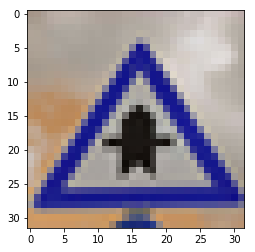

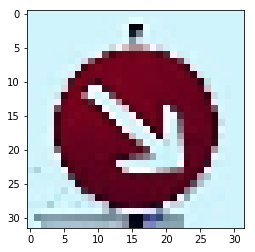

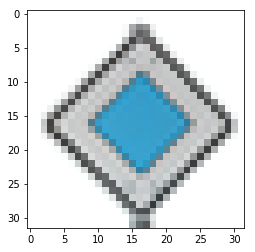

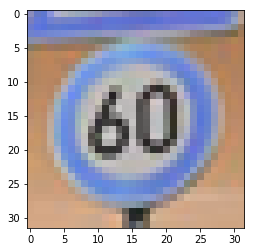

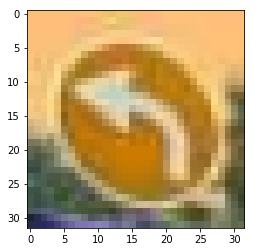

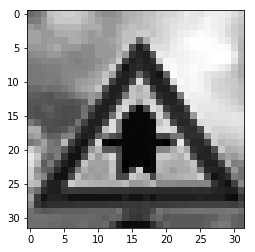

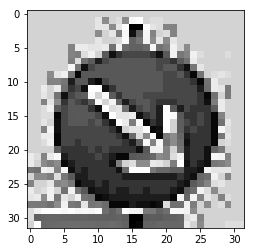

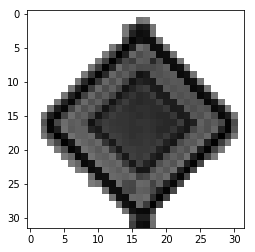

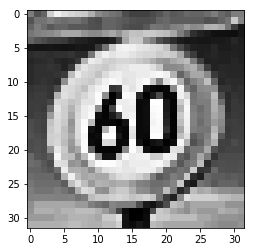

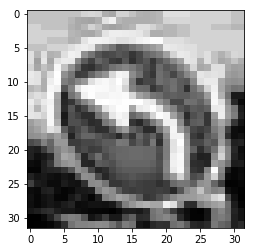

In [50]:

image1 = cv2.imread("Real-World/1.png")
plt.imshow(image1[:,:])
plt.figure()
image2 = cv2.imread("Real-World/5.png")
plt.imshow(image2[:,:])
plt.figure()
image3 = cv2.imread("Real-World/3.png")
plt.imshow(image3[:,:])
plt.figure()
image4 = cv2.imread("Real-World/10.png")
plt.imshow(image4[:,:])
plt.figure()
image5 = cv2.imread("Real-World/6.png")
plt.imshow(image5)
plt.figure()


### Load the images and plot them here.
### Feel free to use as many code cells as needed.
image1 = cv2.imread("Real-World/1.png",0)
image1 = cv2.equalizeHist(image1)
image1 = np.expand_dims(image1, axis=2)
cv2.imwrite(str(path)+"Sign1.png",image1)
plt.imshow(image1[:,:,0], cmap='gray')
plt.figure()

image2 = cv2.imread("Real-World/5.png",0)
image2 = cv2.equalizeHist(image2)
image2 = np.expand_dims(image2, axis=2)
cv2.imwrite(str(path)+"Sign2.png",image2)
plt.imshow(image2[:,:,0], cmap='gray')
plt.figure()

image3 = cv2.imread("Real-World/3.png",0)
image3 = cv2.equalizeHist(image3)
image3 = np.expand_dims(image3, axis=2)
cv2.imwrite(str(path)+"Sign3.png",image3)
plt.imshow(image3[:,:,0], cmap='gray')
plt.figure()

image4 = cv2.imread("Real-World/10.png",0)
image4 = cv2.equalizeHist(image4)
image4 = np.expand_dims(image4, axis=2) 
cv2.imwrite(str(path)+"Sign4.png",image4)
plt.imshow(image4[:,:,0], cmap='gray')
plt.figure()

image5 = cv2.imread("Real-World/6.png",0)
image5 = cv2.equalizeHist(image5)
image5 = np.expand_dims(image5, axis=2)
cv2.imwrite(str(path)+"Sign5.png",image5)
print(image5.shape)
plt.imshow(image5[:,:,0], cmap='gray')
plt.figure()

In [ ]:
feature = {1:image1,2:image2,3:image3,4:image4,5:image5}
data = {"features":[image1,image2,image3,image4,image5],"labels":[35,25,34,17,13]}
with open("/home/charan/Desktop/Car/Term1/CarND-Traffic-Sign-Classifier-Project/Test_images/ftest.p", "wb") as f:
    pickle.dump(data ,f)
    f.close()
    
final_testing_file = "/home/charan/Desktop/Car/Term1/CarND-Traffic-Sign-Classifier-Project/Test_images/ftest.p"
with open(final_testing_file, mode='rb') as f:
    ftest = pickle.load(f)
    
    
print("Final Testing Set: {}".format(len(ftest)))    
y_ftest, X_ftest = ftest["labels"], ftest["features"]
k = np.where(np.array(ftest["labels"]))
print(k)

In [ ]:
Final Testing Set: 2
(array([0, 1, 2, 3, 4]),)

Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #batch_x = X_ftest[offset:end]
    #batch_y = y_ftest[offset:end]
    
    test_accuracy = evaluate(batch_x, batch_y)
    print("Final Test Accuracy = {: .3f}".format(test_accuracy))

In [ ]:
 
Final Test Accuracy =  1.000

Output Top 5 Softmax Probabilities For Each Image Found on the Web
For each of the new images, print out the model's softmax probabilities to show the certainty of the model's predictions (limit the output to the top 5 probabilities for each image). tf.nn.top_k could prove helpful here.
The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.
tf.nn.top_k will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.
Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. tk.nn.top_k is used to choose the three classes with the highest probability:
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
Running it through sess.run(tf.nn.top_k(tf.constant(a), k=3)) produces:
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
Looking just at the first row we get [ 0.34763842,  0.24879643,  0.12789202], you can confirm these are the 3 largest probabilities in a. You'll also notice [3, 0, 5] are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    i = 0
    for i in range(5):
        softmax_prob = sess.run(tf.nn.softmax(logits), feed_dict={x:X_ftest})
        kvalue = sess.run(tf.nn.top_k(tf.constant(softmax_prob), k = 5))
        print(kvalue)
        fig = plt.figure(figsize=(30,2))
        a = fig.add_subplot(1,2,1) 
        a.imshow(X_ftest[i][:,:,0], cmap='gray')
        a=fig.add_subplot(1,2,2) 
        a.set_xticks(np.arange(0,43,1))
        plt.plot(softmax_prob[i])
        for tick in a.xaxis.get_major_ticks():
            tick.label.set_fontsize('x-small') 
            tick.label.set_rotation('vertical')
        plt.grid()
        plt.show()
        i+=1

TopKV2(values=array([[  1.00000000e+00,   1.11263795e-18,   7.21095911e-21,
          6.93602906e-30,   1.19371809e-33],
       [  1.00000000e+00,   1.17488196e-14,   8.16101475e-16,
          3.43900856e-16,   1.73619950e-19],
       [  1.00000000e+00,   1.49577449e-17,   2.18019332e-18,
          3.85529814e-24,   2.03955865e-24],
       [  1.00000000e+00,   2.39624128e-30,   1.98428167e-30,
          1.59752527e-31,   2.72556820e-32],
       [  1.00000000e+00,   3.54210487e-22,   2.56652333e-27,
          3.50760473e-28,   2.62739395e-29]], dtype=float32), indices=array([[35,  9, 12, 13,  3],
       [25, 29, 30, 31, 19],
       [34, 38, 17, 41, 11],
       [17, 35, 23, 20, 37],
       [13, 35, 15, 33,  3]], dtype=int32))

TopKV2(values=array([[  1.00000000e+00,   1.11263795e-18,   7.21095911e-21,
          6.93602906e-30,   1.19371809e-33],
       [  1.00000000e+00,   1.17488196e-14,   8.16101475e-16,
          3.43900856e-16,   1.73619950e-19],
       [  1.00000000e+00,   1.49577449e-17,   2.18019332e-18,
          3.85529814e-24,   2.03955865e-24],
       [  1.00000000e+00,   2.39624128e-30,   1.98428167e-30,
          1.59752527e-31,   2.72556820e-32],
       [  1.00000000e+00,   3.54210487e-22,   2.56652333e-27,
          3.50760473e-28,   2.62739395e-29]], dtype=float32), indices=array([[35,  9, 12, 13,  3],
       [25, 29, 30, 31, 19],
       [34, 38, 17, 41, 11],
       [17, 35, 23, 20, 37],
       [13, 35, 15, 33,  3]], dtype=int32))

TopKV2(values=array([[  1.00000000e+00,   1.11263795e-18,   7.21095911e-21,
          6.93602906e-30,   1.19371809e-33],
       [  1.00000000e+00,   1.17488196e-14,   8.16101475e-16,
          3.43900856e-16,   1.73619950e-19],
       [  1.00000000e+00,   1.49577449e-17,   2.18019332e-18,
          3.85529814e-24,   2.03955865e-24],
       [  1.00000000e+00,   2.39624128e-30,   1.98428167e-30,
          1.59752527e-31,   2.72556820e-32],
       [  1.00000000e+00,   3.54210487e-22,   2.56652333e-27,
          3.50760473e-28,   2.62739395e-29]], dtype=float32), indices=array([[35,  9, 12, 13,  3],
       [25, 29, 30, 31, 19],
       [34, 38, 17, 41, 11],
       [17, 35, 23, 20, 37],
       [13, 35, 15, 33,  3]], dtype=int32))

TopKV2(values=array([[  1.00000000e+00,   1.11263795e-18,   7.21095911e-21,
          6.93602906e-30,   1.19371809e-33],
       [  1.00000000e+00,   1.17488196e-14,   8.16101475e-16,
          3.43900856e-16,   1.73619950e-19],
       [  1.00000000e+00,   1.49577449e-17,   2.18019332e-18,
          3.85529814e-24,   2.03955865e-24],
       [  1.00000000e+00,   2.39624128e-30,   1.98428167e-30,
          1.59752527e-31,   2.72556820e-32],
       [  1.00000000e+00,   3.54210487e-22,   2.56652333e-27,
          3.50760473e-28,   2.62739395e-29]], dtype=float32), indices=array([[35,  9, 12, 13,  3],
       [25, 29, 30, 31, 19],
       [34, 38, 17, 41, 11],
       [17, 35, 23, 20, 37],
       [13, 35, 15, 33,  3]], dtype=int32))

TopKV2(values=array([[  1.00000000e+00,   1.11263795e-18,   7.21095911e-21,
          6.93602906e-30,   1.19371809e-33],
       [  1.00000000e+00,   1.17488196e-14,   8.16101475e-16,
          3.43900856e-16,   1.73619950e-19],
       [  1.00000000e+00,   1.49577449e-17,   2.18019332e-18,
          3.85529814e-24,   2.03955865e-24],
       [  1.00000000e+00,   2.39624128e-30,   1.98428167e-30,
          1.59752527e-31,   2.72556820e-32],
       [  1.00000000e+00,   3.54210487e-22,   2.56652333e-27,
          3.50760473e-28,   2.62739395e-29]], dtype=float32), indices=array([[35,  9, 12, 13,  3],
       [25, 29, 30, 31, 19],
       [34, 38, 17, 41, 11],
       [17, 35, 23, 20, 37],
       [13, 35, 15, 33,  3]], dtype=int32))


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")